In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt
import random

# Generazione di un modello sintetico di camera

1. Generiamo N punti casuali in uno spazio di scena [-5000 < x,y,z < +5000]


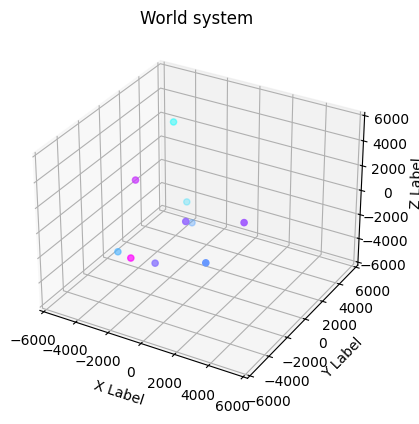

In [2]:
N = 10   # N: 10 punti

x = np.array(random.sample(range(-5000, 5000), N))
y = np.array(random.sample(range(-5000, 5000), N))
z = np.array(random.sample(range(-5000, 5000), N))
P = np.transpose(np.stack((x.T,y.T,z.T), axis=1))
colors = np.random.rand(N)

# Vediamo i punti nel loro spazio di scena
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set(xlim=(-6000, 6000), ylim=(-6000, 6000), zlim=(-6000, 6000))
ax.scatter(x, y, z, marker='o', c=colors, cmap='cool')

ax.set_title("World system")
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


2. Definisco una camera tale che:
- abbia distanza focale 2000
- centro ottico al centro del piano immagine di dimensione $(3000 \times 2000)$, quindi:  $x_c =1500, y_c = 1000$

- sia allineata alla terna di scena (niente rotazione) e
- abbia distanza 12000 pixel lungo l'asse Z (tz = 12000)


In [3]:
#Matrice parametri INTRINSECI
K = np.array([[2000, 0, 1500, 0], [0, 2000, 1000, 0], [0, 0, 1, 0]])
print('K (matrice Intrinseca):')
print(K.astype(int))
print('\n')

# Matrice parametri ESTRINSECI
E = np.zeros((4,4))
E[0:3,0:3] = np.identity(3) #Rotazione neutra
E[0:3,3] = [ 0 , 0 , 12000] #Traslazione solo lungo Z
E[3,3] = 1 #coord omogenee

print('E (matrice Estrinseca):')
print(E.astype(int))
print('\n')


# Costruisco la MATRICE DI PROIEZIONE M, prodotto di K ed E
M = np.dot(K,E)
print('M (matrice di Proiezione):')
print(M.astype(int))

K (matrice Intrinseca):
[[2000    0 1500    0]
 [   0 2000 1000    0]
 [   0    0    1    0]]


E (matrice Estrinseca):
[[    1     0     0     0]
 [    0     1     0     0]
 [    0     0     1 12000]
 [    0     0     0     1]]


M (matrice di Proiezione):
[[    2000        0     1500 18000000]
 [       0     2000     1000 12000000]
 [       0        0        1    12000]]


# Generazione dei punti immagine $p_{im}$ in base ai punti $P$ e al modello di camera dato

In [9]:
#Mediante la matrice M, proietto i punti di scena P, generando i punti
#immagine p_im.
#Per farlo, devo passare prima in coordinate omogenee (P_tilde e p_im_tilde)

# Punti di scena P in coordinate omogenee => P_tilde
P_tilde = np.ones((4, N))
P_tilde[0:3, :] = P

# Proietto sul piano immagine i punti mondo in coord omogenee
p_im_tilde = np.dot(M, P_tilde)
print(np.shape(p_im_tilde))

(3, 10)


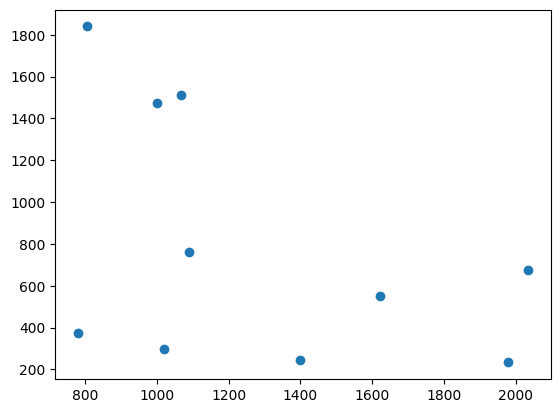

In [10]:
#Coordinate immagine euclidee
p_im_x = np.array(p_im_tilde[0,:]/p_im_tilde[2,:])
p_im_y = np.array(p_im_tilde[1,:]/p_im_tilde[2,:])
#p_im = np.transpose(np.stack((p_im_x, p_im_y), axis = 1))
p_im = np.vstack((p_im_x, p_im_y))
fig = plt.figure()
plt.scatter(p_im_x, p_im_y, marker='o')


# Calibrazione

Calibrazione della camera utilizzando l'algoritmo lineare (partendo dalla conoscenza di $P$ e di $p_{im}$ si determina $M$)

1. Costruzione di $P_{sol}$: la matrice del sistema lineare $2N \times 12$

In [11]:
# Algoritmo lineare: costruisco la matrice del sistema lineare 2N x 12 (P_sol) come da algoritmo:
P_sol  = []
for i in range(N):
  row_1 =  np.hstack((P_tilde[:,i], np.zeros(4), -p_im[0,i]*P_tilde[:,i].T))
  row_2 =  np.hstack((np.zeros(4), P_tilde[:,i], -p_im[1,i]*P_tilde[:,i].T))
  P_sol.append(row_1)
  P_sol.append(row_2)

P_sol = np.array(P_sol)


2. Applicazione della SVD e selezione dell'ultima riga

In [14]:
u, s, vh = np.linalg.svd(P_sol)
m_sol = vh[-1,:] #in PYTHON , ultima riga!
 

3. Ricomposizione della matrice $M$ a partire dal vettore $m_{sol}$

In [15]:
M_cal = m_sol.reshape(3,4)

# M_cal deve risultare uguale alla matrice di partenza, M, a meno di un
# fattore di scala. Per confrontare quindi M con Mcal, le devo normalizzare
# a un fattore di scala comune. Scelgo, ad esempio, di riscalare entrambe
# in modo da avere M[0,3]=100
M_cal_rescaled = M_cal *100 /M_cal[0,3]
M_rescaled = M *100 /M[0,3]
print('M calibrated and rescaled: ')
print (M_cal_rescaled.astype(int))
print('\n')

print('M orig rescaled: ')
print (M_rescaled.astype(int))


M calibrated and rescaled: 
[[ 0  0  0 99]
 [ 0  0  0 66]
 [ 0  0  0  0]]


M orig rescaled: 
[[  0   0   0 100]
 [  0   0   0  66]
 [  0   0   0   0]]


4. Applicazione dell'algoritmo "QR factorization" per recuperare le matrici con i parametri intrinseci $K$ e la matrice di rotazione $R$

In [16]:
R, K = np.linalg.qr(M[0:3,0:3])

print("K =\n", K.astype(int))
print("R =\n", R.astype(int))

K =
 [[2000    0 1500]
 [   0 2000 1000]
 [   0    0    1]]
R =
 [[1 0 0]
 [0 1 0]
 [0 0 1]]


5. determinazione del vettore di tralazione e ricostruzione della matrice dei parametri estrinseci

In [17]:
t = np.dot(np.linalg.inv(K), M[0:3, 3])

E = np.zeros((4,4))
E[0:3,0:3]=R
E[0:3, 3] = t

print("E =\n", E.astype(int))

E =
 [[    1     0     0     0]
 [    0     1     0     0]
 [    0     0     1 12000]
 [    0     0     0     0]]
